In [4]:
import xmltodict
import json
import os
import re
import random

import numpy as np
import pandas as pd

import torchvision
import torch

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from pycocotools.coco import COCO
from PIL import Image
import xml.etree.ElementTree as ET
from shutil import copyfile
import albumentations as A

from sklearn.model_selection import train_test_split
from collections import defaultdict

from torch.utils.data import DataLoader, Dataset, random_split
# import torchvision.transforms as T
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torchvision import io, utils
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
import PIL.Image
from torchvision import tv_tensors

In [19]:
cvat_file_2 = 'C:/Users/Anastasia/Downloads/13classes.xml'
coco_file_2 = 'C:/Users/Anastasia/Downloads/13classes.json'
project_path = "C:/Users/Anastasia/Downloads/cell-detection-13class-filtered"
images13_path = "C:/Users/Anastasia/Downloads/cell-detection-13class-filtered/images/"

In [6]:
# Обработка файла с аннотацией xml в COCO
import xml.etree.ElementTree as ET
import re

def parse_cvat_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = []
    category_mapping = {
        'panels': 'facade',
        'facing_bricks': 'facade',
        'walls_plaster': 'plaster',
        'primer_plaster': 'plaster'
    }

    for image in root.findall('image'):
        file_name = image.get('name')
        width = int(image.get('width'))
        height = int(image.get('height'))

        camera_match = re.search(r'_snapshot__(\d+)__', file_name)
        camera = camera_match.group(1) if camera_match else 'unknown'

        for box in image.findall('box'):
            xtl = float(box.get('xtl'))
            ytl = float(box.get('ytl'))
            xbr = float(box.get('xbr'))
            ybr = float(box.get('ybr'))
            width_box = xbr - xtl
            height_box = ybr - ytl

            # Convert bbox to Faster R-CNN format (x1, y1, x2, y2)
            x_min = xtl
            y_min = ytl
            x_max = xbr
            y_max = ybr

            attributes = {attr.get('name'): attr.text for attr in box.findall('attribute')}
            category_ids = [category_mapping.get(key, key) for key, value in attributes.items() if value.lower() == 'true']

            annotations.append({
                'file_name': file_name,
                'width': width,
                'height': height,
                'camera': camera,
                'bbox': [x_min, y_min, x_max, y_max],
                'categories': category_ids
            })

    return annotations

In [7]:
annotations_2 = parse_cvat_annotations(cvat_file_2)

In [8]:
len(annotations_2)

45657

In [9]:
annotations_2[35003]

{'file_name': '3497_snapshot__13__2022-11-29.jpg',
 'width': 4032,
 'height': 3024,
 'camera': '13',
 'bbox': [352.71, 889.77, 525.13, 1024.44],
 'categories': ['wall_masonry', 'windows']}

In [11]:
for i in range(3):
    print(annotations_2[i])

{'file_name': '10082_snapshot__20__2023-01-29.jpg', 'width': 1520, 'height': 2688, 'camera': '20', 'bbox': [363.1, 1248.6, 515.7, 1376.81], 'categories': ['insulation', 'windows']}
{'file_name': '10082_snapshot__20__2023-01-29.jpg', 'width': 1520, 'height': 2688, 'camera': '20', 'bbox': [239.17, 1130.51, 361.84, 1258.72], 'categories': ['windows', 'insulation']}
{'file_name': '10082_snapshot__20__2023-01-29.jpg', 'width': 1520, 'height': 2688, 'camera': '20', 'bbox': [391.37, 1026.55, 540.6, 1154.76], 'categories': ['windows', 'insulation']}


In [8]:
# Точечное отображение разметки ячейки с классами
def plot_images_with_boxes(annotations, image_dir, num_images=5):
    sampled_annotations = random.sample(annotations, min(num_images, len(annotations)))

    for annotation in sampled_annotations:
        img_path = os.path.join(image_dir, annotation['file_name'])
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue

        img = plt.imread(img_path)
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        bbox = annotation['bbox']
        x_min, y_min, x_max, y_max = bbox

        # Draw bounding box
        rect = patches.Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min),
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Display categories
        categories = annotation['categories']
        category_text = '\n'.join(categories)
        ax.text(x_min, y_min, category_text, verticalalignment='top', color='white',
                bbox={'facecolor': 'white', 'alpha': 0.5})

        plt.axis('off')
        plt.show()

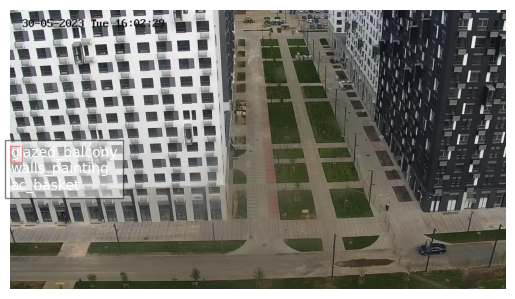

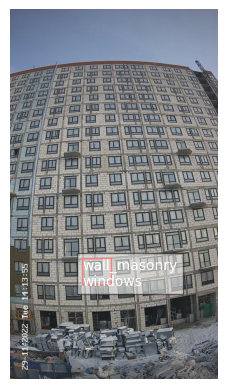

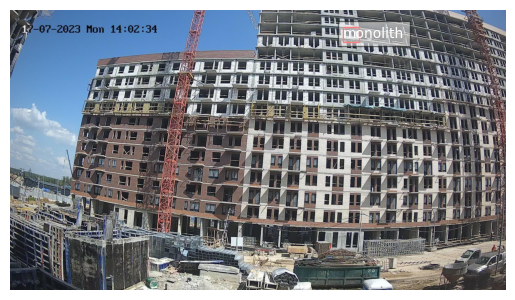

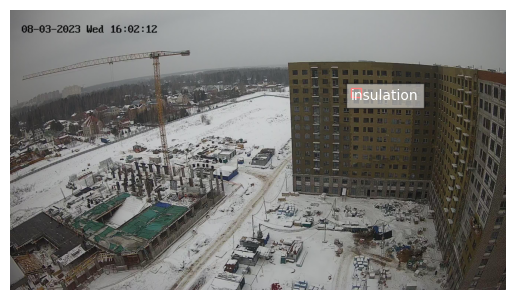

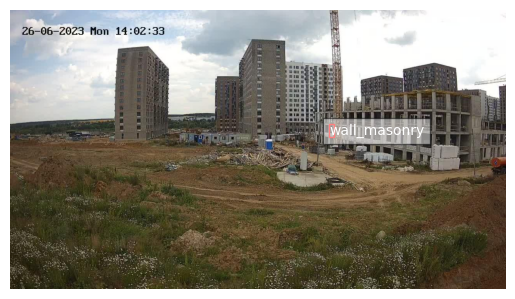

In [9]:
plot_images_with_boxes(annotations_2, images13_path)

In [12]:
# Разделение аннотации с учетом камер, которые их фотографировали
def split_annotations_by_camera(annotations, train_ratio=0.8):
    # Группировка аннотаций по номерам камер
    annotations_by_camera = defaultdict(list)
    for annotation in annotations:
        camera = annotation['camera']
        annotations_by_camera[camera].append(annotation)

    train_annotations = []
    val_annotations = []

    # Разделение каждой группы на тренировочные и валидационные наборы
    for camera, camera_annotations in annotations_by_camera.items():
        random.shuffle(camera_annotations)  # Перемешивание аннотаций в группе
        train_size = int(train_ratio * len(camera_annotations))
        train_annotations.extend(camera_annotations[:train_size])
        val_annotations.extend(camera_annotations[train_size:])

    return train_annotations, val_annotations

In [13]:
# Создание аннотаций для трейна и валидации пропорционально фоткам с камер
train_annotations, val_annotations = split_annotations_by_camera(annotations_2, train_ratio=0.8)
print(f"Number of training annotations: {len(train_annotations)}")
print(f"Number of validation annotations: {len(val_annotations)}")

# Проверка распределения камер
train_cameras = set([ann['camera'] for ann in train_annotations])
val_cameras = set([ann['camera'] for ann in val_annotations])
print(f"Training cameras: {train_cameras}")
print(f"Validation cameras: {val_cameras}")

Number of training annotations: 36494
Number of validation annotations: 9163
Training cameras: {'26', '80', '47', '82', '27', '99', '91', '20', '101', '77', '41', '15', '98', '36', '100', '87', '2', '9', '38', '42', '31', '52', '88', '96', '45', '105', '24', '40', '32', '10', '1', '28', '48', '103', '78', '37', '70', '109', '16', '81', '18', '35', '73', '89', '21', '108', '33', '84', '49', '17', '8', '34', '50', '4', '97', '90', '110', '29', '56', '46', '14', '23', '3', '13', '54', '104', '43', '44', '19', '53', '25', '107', '51'}
Validation cameras: {'26', '80', '47', '82', '27', '99', '91', '20', '101', '77', '41', '15', '98', '36', '100', '87', '2', '9', '38', '42', '31', '52', '88', '96', '45', '105', '24', '40', '32', '10', '1', '28', '48', '103', '78', '37', '70', '109', '16', '81', '18', '35', '73', '89', '21', '108', '33', '84', '49', '17', '8', '34', '50', '4', '97', '90', '110', '29', '56', '46', '14', '23', '3', '13', '54', '104', '43', '44', '19', '53', '25', '107', '51'}


In [14]:
# Получение всех уникальных категорий
unique_categories = set()
for annotation in annotations_2:
    unique_categories.update(annotation['categories'])

print("Уникальные категории:")
print(unique_categories)

Уникальные категории:
{'glazed_balcony', 'wall_masonry', 'facade', 'vent_subsustem', 'windows', 'tiling', 'insulation', 'ac_basket', 'walls_painting', 'plaster', 'monolith'}


In [13]:
target_bbox = 363.1

for annotation in train_annotations:
    if annotation['bbox'][0] == target_bbox:
        print("Найден bbox с указанными координатами:")
        print(annotation)
        break
else:
    print("bbox с указанными координатами не найден.")

Найден bbox с указанными координатами:
{'file_name': '10082_snapshot__20__2023-01-29.jpg', 'width': 1520, 'height': 2688, 'camera': '20', 'bbox': [363.1, 1248.6, 515.7, 1376.81], 'categories': ['insulation', 'windows']}


In [11]:
# Долгая проверка, нет ли таких фотографий, где метки выходят за рамки
# def check_bboxes(annotations, image_folder):
#     problematic_files = []

#     for annotation in annotations:
#         img_path = os.path.join(image_folder, annotation['file_name'])
#         if not os.path.exists(img_path):
#             print(f"File not found: {img_path}")
#             continue

#         image = Image.open(img_path)
#         image_width, image_height = image.size

#         bbox = annotation['bbox']
#         x_min, y_min, x_max, y_max = bbox

#         if x_min < 0 or y_min < 0 or x_max >= image_width or y_max >= image_height:
#             problematic_files.append(annotation['file_name'])

#     return problematic_files

# # Пример использования для вашего кастомного датасета
# problematic_files = check_bboxes(annotations_2, images13_path)

# if problematic_files:
#     print("Найдены файлы с bbox, выходящими за пределы изображения:")
#     for file_name in problematic_files:
#         print(file_name)
# else:
#     print("Все bbox в пределах размеров изображений.")

In [15]:
# Предобработка датасетов
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, image_folder, transform=None):
        self.annotations = annotations
        self.image_folder = image_folder
        self.transform = transform

        self.category_map = {
            'windows': 0,
            'glazed_balcony': 1,
            'monolith': 2,
            'wall_masonry': 3,
            'walls_painting': 4,
            'insulation': 5,
            'facade': 6,
            'plaster': 7,
            'tiling': 8,
            'ac_basket': 9,
            'vent_subsustem': 10
        }
        self.num_classes = len(self.category_map)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_folder, annotation['file_name'])
        image = Image.open(img_path).convert('RGB')

        bbox = annotation['bbox']
        bbox = torch.tensor(bbox, dtype=torch.float32).view(-1, 4)  # [1, 4]

        categories = annotation['categories']

        # Преобразуем категории в индексы классов
        labels = [self.category_map[cat] for cat in categories]

        if self.transform:
            image = self.transform(image)

        labels = torch.tensor(labels, dtype=torch.int64)  # [num_labels]

        target = {'boxes': bbox, 'labels': labels}

        return image, target


In [16]:
# Аугментация
train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor()
])

val_transforms = T.Compose([
    T.ToTensor()
])

C:\Users\Anastasia\anaconda3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [22]:
train_annotations[0]

{'file_name': '36165_snapshot__20__2023-09-15.jpg',
 'width': 2688,
 'height': 1520,
 'camera': '20',
 'bbox': [832.77, 734.24, 957.98, 825.95],
 'categories': ['windows', 'tiling']}

In [20]:
# Деление на трейн и валидацию
train_dataset = CustomDataset(random.sample(train_annotations, 100), images13_path, transform=train_transforms)
val_dataset = CustomDataset(random.sample(train_annotations, 20), images13_path, transform=val_transforms)

In [21]:
for i in range(2):
    print(train_dataset[i])

(tensor([[[0.5608, 0.5490, 0.5451,  ..., 0.5451, 0.5451, 0.5451],
         [0.4431, 0.4275, 0.4235,  ..., 0.5451, 0.5451, 0.5451],
         [0.3529, 0.3451, 0.3137,  ..., 0.5451, 0.5451, 0.5451],
         ...,
         [0.4157, 0.3725, 0.4353,  ..., 0.3333, 0.3333, 0.3333],
         [0.4235, 0.4471, 0.4431,  ..., 0.3333, 0.3333, 0.3333],
         [0.4235, 0.4431, 0.3804,  ..., 0.3333, 0.3333, 0.3333]],

        [[0.5137, 0.4980, 0.4941,  ..., 0.9725, 0.9725, 0.9725],
         [0.4000, 0.3922, 0.3725,  ..., 0.9725, 0.9725, 0.9725],
         [0.3333, 0.3176, 0.2902,  ..., 0.9725, 0.9725, 0.9725],
         ...,
         [0.5569, 0.5137, 0.5765,  ..., 0.3333, 0.3333, 0.3333],
         [0.5608, 0.5922, 0.5843,  ..., 0.3333, 0.3333, 0.3333],
         [0.5608, 0.5843, 0.5255,  ..., 0.3333, 0.3333, 0.3333]],

        [[0.5451, 0.5294, 0.5255,  ..., 0.9882, 0.9882, 0.9882],
         [0.4392, 0.4078, 0.4157,  ..., 0.9882, 0.9882, 0.9882],
         [0.3647, 0.3451, 0.3216,  ..., 0.9882, 0.9882, 0

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_dataset(dataset, idx):
    image, target = dataset[idx]
    image = image.permute(1, 2, 0).numpy()  # Переводим изображение в формат (H, W, C) для matplotlib
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()

    # Создаем новое окно для визуализации
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Рисуем прямоугольники bbox
    for i in range(len(boxes)):
        x_min, y_min, x_max, y_max = boxes[i]
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'class {labels}', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


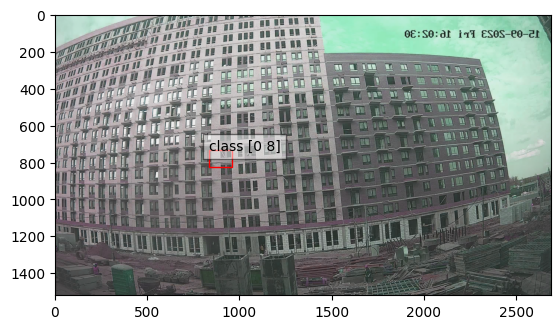

In [24]:
visualize_dataset(train_dataset, 0)

In [22]:
# Приводим фотки к единой размерности (дополняем до максимальной по размеру фотки, чтобы избежать проблем во время обучения)
def collate_fn_padd(batch):
    max_w = 0
    max_h = 0

    for i in range(len(batch)):
        _, h, w = batch[i][0].shape
        if h > max_h:
            max_h = h
        if w > max_w:
            max_w = w

    padded_imgs = []
    target = []

    for i in range(len(batch)):
        # padding
        pad_y = max_h - batch[i][0].shape[1]
        pad_x = max_w - batch[i][0].shape[2]
        padded_image = torchvision.transforms.Pad((0, 0, pad_x, pad_y))(batch[i][0])
        padded_imgs.append(padded_image)

        # rearranging target
        boxes_t = batch[i][1]['boxes']
        labels_t = batch[i][1]['labels']
        target.append({'boxes': boxes_t, 'labels': labels_t})

    return torch.stack(padded_imgs), target

In [23]:
# Создаем лоадеры
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn_padd)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn_padd)

In [41]:
# # Преобразуем train_loader в итератор
# train_loader_iter = iter(train_loader)

# # Получаем первый элемент из train_loader
# images, targets = next(train_loader_iter)

# # Теперь можно просмотреть images и targets
# print(images[0])
# print(targets[0])

tensor([[[0.8706, 0.8706, 0.8706,  ..., 0.0000, 0.0000, 0.0000],
         [0.8706, 0.8706, 0.8706,  ..., 0.0000, 0.0000, 0.0000],
         [0.8706, 0.8706, 0.8706,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.0000, 0.0000, 0.0000],
         [0.8745, 0.8745, 0.8745,  ..., 0.0000, 0.0000, 0.0000],
         [0.8745, 0.8745, 0.8745,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.0000, 0.0000, 0.0000],
         [0.8745, 0.8745, 0.8745,  ..., 0.0000, 0.0000, 0.0000],
         [0.8745, 0.8745, 0.8745,  ..., 0.0000, 0.0000, 0.

In [42]:
# target_bbox = [4111.3999, 710.5000, 4209.5000, 947.5000]

# for i, (image, target) in enumerate(train_dataset):
#     boxes = target['boxes']
#     # Проверяем каждый bbox в списке на соответствие target_bbox
#     if any(all(x == target_bbox[j] for j, x in enumerate(box)) for box in boxes):
#         print(f"Найден bbox с указанными координатами в элементе с индексом {i}:")
#         print(train_dataset[i])
#         break
# else:
#     print("bbox с указанными координатами не найден.")


In [26]:
# Пример получения одного элемента из датасета
image0, target0 = train_dataset[0]
print(f"Image shape: {image0.shape}")
print(f"Target (boxes): {target0['boxes']}, {target0['boxes'].shape}")
print(f"Target (labels): {target0['labels']}, {target0['labels'].shape}")

Image shape: torch.Size([3, 1520, 2688])
Target (boxes): tensor([[832.7700, 734.2400, 957.9800, 825.9500]]), torch.Size([1, 4])
Target (labels): tensor([0, 8]), torch.Size([2])


In [24]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Функция для проверки корректности значений bounding box
def validate_boxes(boxes, image_shape):
    valid = True
    for box in boxes:
        x_min, y_min, x_max, y_max = torch.round(box * 100) / 100
        if not (0 <= x_min < x_max <= image_shape[2] and 0 <= y_min < y_max <= image_shape[1]):
            valid = False
            break
    return valid

# Подготовка модели
def get_model(num_classes):
    # Загружаем предобученную модель
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    # Получаем количество входных признаков для классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Заменяем предсказатель головы на новый
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

num_classes = len(train_dataset.category_map) + 1  # Плюс один для фона
model = get_model(num_classes)

# Оптимизатор и параметры обучения
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Anastasia/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:09<00:00, 17.0MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Обучение модели на трейне 
import time

model.train()
num_epochs = 10
for epoch in range(num_epochs):
    epoch_losses = []
    start_time = time.time()

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        epoch_losses.append(losses.item())

    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Time: {epoch_time:.2f} seconds")

Epoch 1, Loss: 0.5234313562512398, Time: 2724.45 seconds
Epoch 2, Loss: 0.21428414918482303, Time: 2436.97 seconds


In [ ]:
import time
from sklearn.metrics import f1_score

# Оценка модели на валидации
model.eval()
all_true_labels = []
all_pred_labels = []

start_time = time.time()

with torch.no_grad():
    for images, targets in val_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i in range(len(outputs)):
            true_labels = targets[i]['labels'].cpu().numpy()
            pred_labels = outputs[i]['labels'].cpu().numpy()

            all_true_labels.extend(true_labels)
            all_pred_labels.extend(pred_labels)

end_time = time.time()
evaluation_time = end_time - start_time

f1_macro = f1_score(all_true_labels, all_pred_labels, average='macro')
print(f"F1 Score (Macro): {f1_macro:.4f}, Evaluation Time: {evaluation_time:.2f} seconds")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Функция для рисования рамки с меткой класса и подписью
def draw_boxes(ax, boxes, labels, true_labels, class_map):
    for box, label, true_label in zip(boxes, labels, true_labels):
        x_min, y_min, x_max, y_max = box
        pred_class_name = list(class_map.keys())[list(class_map.values()).index(label)]
        true_class_name = list(class_map.keys())[list(class_map.values()).index(true_label)]
        bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(bbox)
        ax.text(x_min, y_min - 5, f'Pred: {pred_class_name}', fontsize=10, color='blue')
        ax.text(x_min, y_min - 20, f'True: {true_class_name}', fontsize=10, color='green')

# Выбираем случайное изображение для визуализации
idx = np.random.randint(len(val_dataset))
image, target = val_dataset[idx]

# Преобразуем изображение к нужному формату
image_tensor = torch.unsqueeze(image, 0).to(device)

# Получаем предсказания модели
model.eval()
with torch.no_grad():
    outputs = model(image_tensor)

# Извлекаем предсказанные рамки и метки
pred_boxes = outputs[0]['boxes'].cpu().numpy()
pred_labels = outputs[0]['labels'].cpu().numpy()
true_labels = target['labels'].numpy()

# Создаем фигуру для отображения изображения и рамок
fig, ax = plt.subplots(1, figsize=(10, 10))

# Отображаем изображение
ax.imshow(image.permute(1, 2, 0))

# Рисуем предсказанные рамки с подписями
draw_boxes(ax, pred_boxes, pred_labels, true_labels, val_dataset.category_map)

plt.axis('off')
plt.show()